<a href="https://colab.research.google.com/github/Abdulaziz7878/Rossmann_Pharmaceuticals/blob/main/sales_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime

In [12]:
from google.colab import drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [10]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Month,Day,WeekOfYear,DayOfYear,IsWeekend,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,DaysToHoliday,DaysAfterHoliday
0,-1.731640,0.501484,5263,555,0.452399,1.273237,-0.159217,2.144211,0.580451,-0.940975,...,0.346724,1.740766,0.511626,0.489328,1.156189,-0.700515,-0.700517,1.388213,2.953684,2.953684
1,-1.728534,0.501484,6064,625,0.452399,1.273237,-0.159217,2.144211,-0.884348,-0.940975,...,0.346724,1.740766,0.511626,0.489328,1.156189,-0.700515,-0.700517,1.388213,2.953684,2.953684
2,-1.725427,0.501484,8314,821,0.452399,1.273237,-0.159217,2.144211,-0.884348,-0.940975,...,0.346724,1.740766,0.511626,0.489328,1.156189,-0.700515,-0.700517,1.388213,2.953684,2.953684
3,-1.722321,0.501484,13995,1498,0.452399,1.273237,-0.159217,2.144211,0.580451,1.071502,...,0.346724,1.740766,0.511626,0.489328,1.156189,-0.700515,-0.700517,1.388213,2.953684,2.953684
4,-1.719214,0.501484,4822,559,0.452399,1.273237,-0.159217,2.144211,-0.884348,-0.940975,...,0.346724,1.740766,0.511626,0.489328,1.156189,-0.700515,-0.700517,1.388213,2.953684,2.953684


In [15]:
df_test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Month,Day,WeekOfYear,DayOfYear,IsWeekend,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,DaysToHoliday,DaysAfterHoliday
0,1,-1.731640,0.000831,0.452399,1.273237,-0.159217,-0.466372,0.580451,-0.940975,-0.537724,...,0.94803,0.147618,0.996613,0.961694,-0.86491,-0.700515,1.427517,-0.72035,1.241181,1.241181
1,2,-1.725427,0.000831,0.452399,1.273237,-0.159217,-0.466372,-0.884348,-0.940975,1.130186,...,0.94803,0.147618,0.996613,0.961694,-0.86491,-0.700515,1.427517,-0.72035,1.241181,1.241181
2,3,-1.713001,0.000831,0.452399,1.273237,-0.159217,-0.466372,-0.884348,1.071502,2.410301,...,0.94803,0.147618,0.996613,0.961694,-0.86491,-0.700515,1.427517,-0.72035,1.241181,1.241181
3,4,-1.709895,0.000831,0.452399,1.273237,-0.159217,-0.466372,-0.884348,-0.940975,0.272886,...,0.94803,0.147618,0.996613,0.961694,-0.86491,-0.700515,1.427517,-0.72035,1.241181,1.241181
4,5,-1.706789,0.000831,0.452399,1.273237,-0.159217,-0.466372,-0.884348,1.071502,-0.439153,...,0.94803,0.147618,0.996613,0.961694,-0.86491,-0.700515,1.427517,-0.72035,1.241181,1.241181


In [16]:
# Assuming df_train and df_test are already processed and numeric

# Splitting the data into train and validation sets
X = df_train.drop(['Sales', 'Customers'], axis=1)
y = df_train['Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines for numeric and categorical data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Append classifier to preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor(random_state=42))])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Evaluate model performance
print('Mean Squared Error:', mean_squared_error(y_val, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))

# You can now use this pipeline to make predictions on the test set
X_test = df_test.drop(['Id'], axis=1)  # Assuming 'Id' is not needed for prediction
test_predictions = pipeline.predict(X_test)

# Assuming you want to save the predictions to a file
output = pd.DataFrame({'Id': df_test['Id'], 'Sales': test_predictions})


Mean Squared Error: 619609.805058023
Mean Absolute Error: 458.3456651527216


In [18]:
output.to_csv('sales_predictions.csv', index=False)

In [19]:
from google.colab import files

files.download('sales_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
r2 = r2_score(y_val, y_pred)

print('R^2 Score:', r2)

R^2 Score: 0.9581027557716452


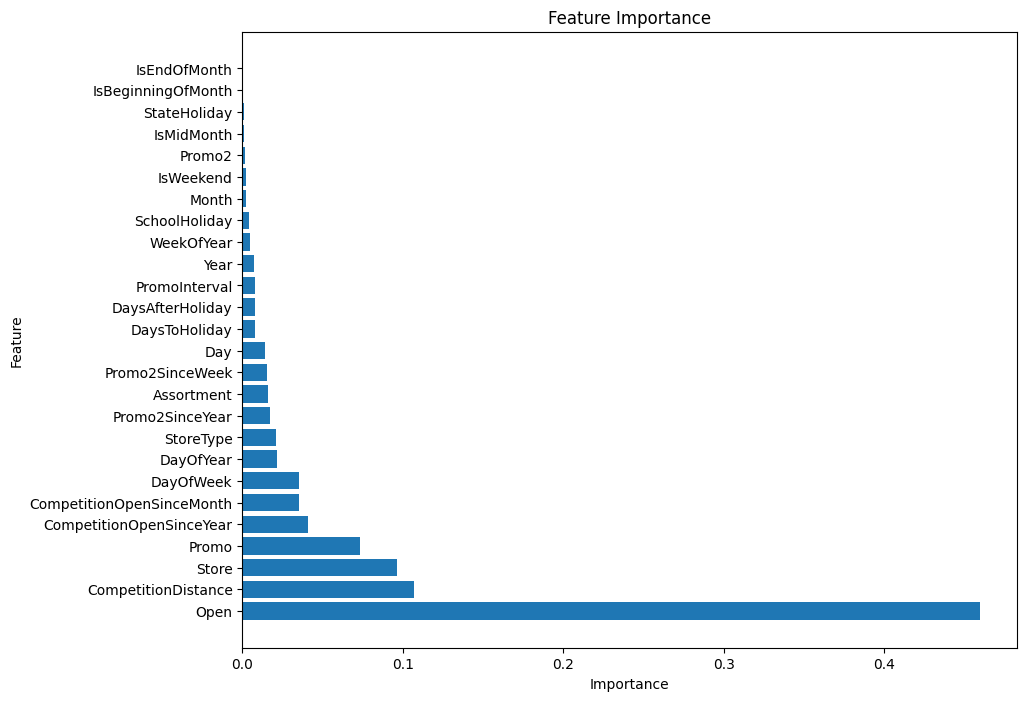

In [21]:
# Get feature importances
feature_importance = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame to hold the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

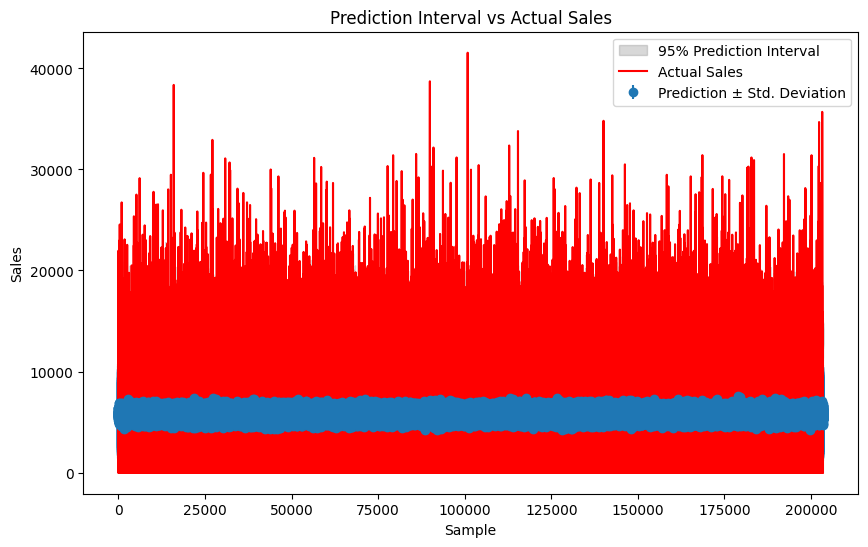

In [22]:
# Number of bootstrap samples
n_bootstrap = 100

# Initialize empty array to store predictions
bootstrap_predictions = np.zeros((len(X_val), n_bootstrap))

# Perform bootstrapping
for i in range(n_bootstrap):
    # Bootstrap sample
    X_boot, y_boot = resample(X_val, y_val, random_state=i)

    # Predict on bootstrap sample
    y_pred_boot = pipeline.predict(X_boot)

    # Store predictions
    bootstrap_predictions[:, i] = y_pred_boot

# Calculate mean and standard deviation of bootstrap predictions
mean_predictions = np.mean(bootstrap_predictions, axis=1)
std_predictions = np.std(bootstrap_predictions, axis=1)

# Calculate 95% prediction interval (PI)
lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=1)
upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=1)

# Plotting confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_val)), mean_predictions, yerr=std_predictions, fmt='o', label='Prediction ± Std. Deviation')
plt.fill_between(range(len(y_val)), lower_bound, upper_bound, alpha=0.3, color='gray', label='95% Prediction Interval')
plt.plot(range(len(y_val)), y_val, 'r-', label='Actual Sales')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.title('Prediction Interval vs Actual Sales')
plt.legend()
plt.show()

In [23]:
# Generate timestamp
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')[:-3]  # Current timestamp in format YYYY-MM-DD-HH-MM-SS-MS

# Serialize and save the model
import joblib
model_filename = f'model_{timestamp}.pkl'

joblib.dump(pipeline, model_filename)

print(f'Model saved as {model_filename}')


Model saved as model_2024-09-23-18-35-19-852.pkl


In [25]:
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Function to create supervised learning data
def create_supervised_data(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)  # Replace NaN values with 0
    return df

In [27]:
df_store_sales = pd.read_csv('/content/drive/MyDrive/store_sales.csv')

In [28]:
# Create supervised learning data with lag 1 (previous day)
lag = 1
supervised = create_supervised_data(df_store_sales, lag)
supervised.columns = ['Previous_Sales', 'Sales']

# Split into input (X) and output (y)
X = supervised['Previous_Sales'].values
y = supervised['Sales'].values

# Reshape input to be 3D [samples, timesteps, features] as required by LSTM
X = X.reshape((len(X), 1, lag))

# Train-test split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Scale data in the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train[:, 0, :].reshape(-1, 1))
X_test_scaled = scaler.transform(X_test[:, 0, :].reshape(-1, 1))
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, lag)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, lag)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 - 2s - 100ms/step - loss: 20151208.0000 - val_loss: 17532626.0000
Epoch 2/100
24/24 - 0s - 4ms/step - loss: 20150426.0000 - val_loss: 17531752.0000
Epoch 3/100
24/24 - 0s - 6ms/step - loss: 20149380.0000 - val_loss: 17530538.0000
Epoch 4/100
24/24 - 0s - 6ms/step - loss: 20147928.0000 - val_loss: 17528858.0000
Epoch 5/100
24/24 - 0s - 4ms/step - loss: 20145950.0000 - val_loss: 17526610.0000
Epoch 6/100
24/24 - 0s - 5ms/step - loss: 20143362.0000 - val_loss: 17523718.0000
Epoch 7/100
24/24 - 0s - 4ms/step - loss: 20140090.0000 - val_loss: 17520116.0000
Epoch 8/100
24/24 - 0s - 4ms/step - loss: 20136084.0000 - val_loss: 17515770.0000
Epoch 9/100
24/24 - 0s - 6ms/step - loss: 20131318.0000 - val_loss: 17510668.0000
Epoch 10/100
24/24 - 0s - 6ms/step - loss: 20125792.0000 - val_loss: 17504820.0000
Epoch 11/100
24/24 - 0s - 4ms/step - loss: 20119524.0000 - val_loss: 17498258.0000
Epoch 12/100
24/24 - 0s - 4ms/step - loss: 20112554.0000 - val_loss: 17491030.0000
Epoch 13/10

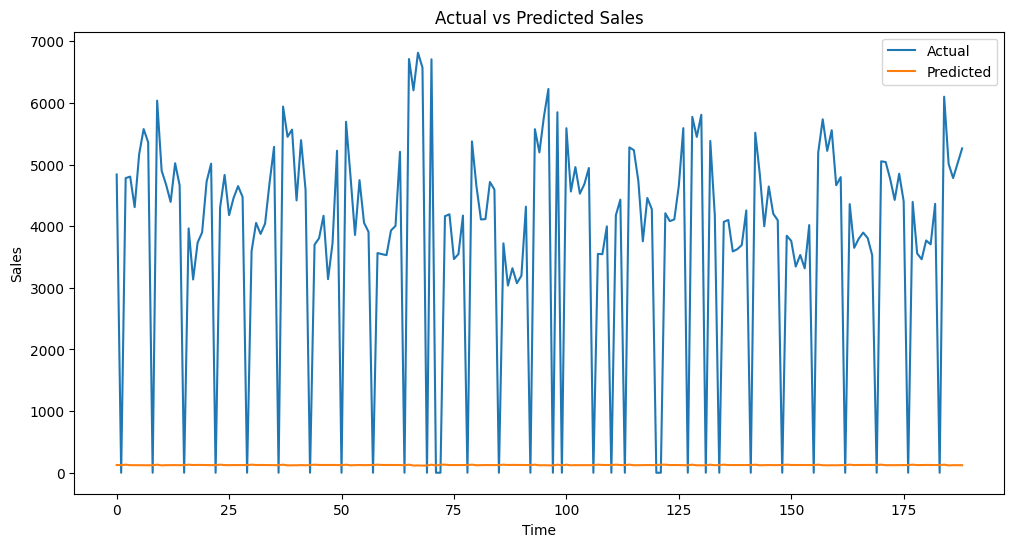

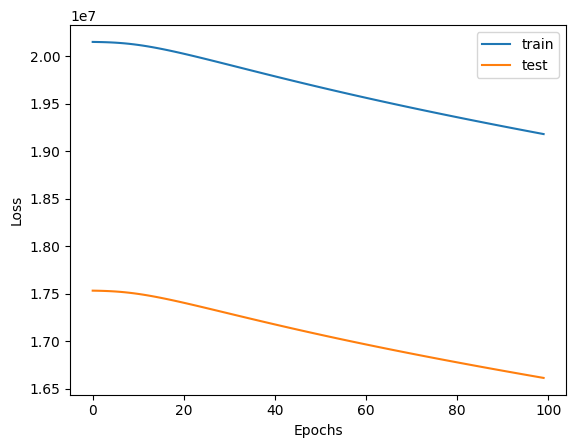

In [29]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2, shuffle=False)

# Predict sales
y_pred = model.predict(X_test_scaled)

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)
print(f'R-squared value: {r2}')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Predict sales
y_pred = model.predict(X_test_scaled)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


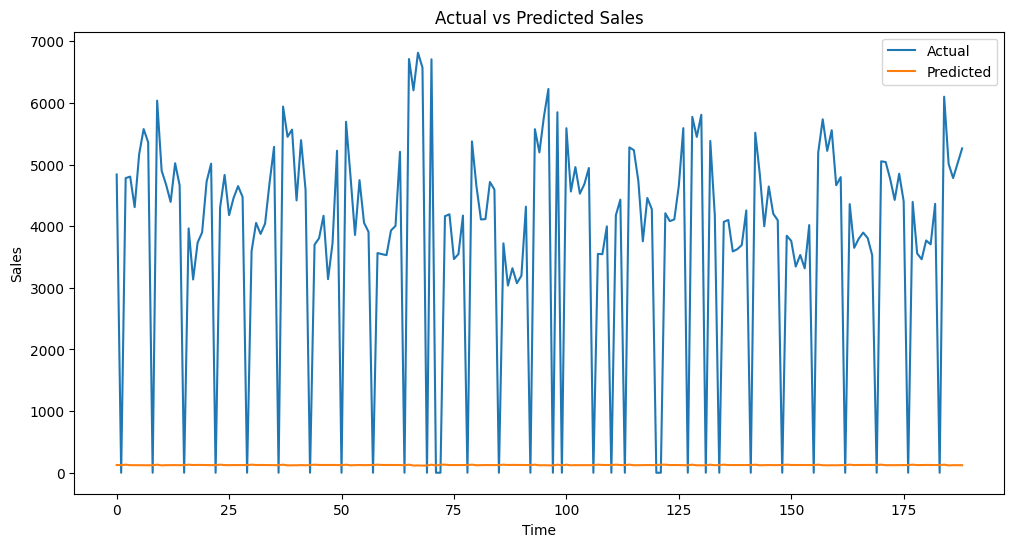

In [31]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [32]:
# Calculate R-squared value

r2 = r2_score(y_test, y_pred)
print(f'R-squared value: {r2}')

R-squared value: -3.7221393041578272


In [33]:
!git config --global user.email "abdulazizdegefa78@gmal.com"
!git config --global user.name "Abdulaziz7878"